<a href="https://colab.research.google.com/github/lawrennd/spectral/blob/main/examples/05_parameter_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Exploration and Selection Guide

## Neil D. Lawrence

## 2026-02-08

This notebook provides a systematic guide to understanding and selecting the key parameters of the spectral clustering algorithm:

1. **Sigma ($\sigma$)**: RBF kernel bandwidth - controls affinity scale
2. **Lambda ($\lambda$)**: Elongation factor for k-means  - controls radial clustering
3. **Max clusters**: Upper bound on automatic detection

We'll explore:
- How each parameter affects clustering
- Guidelines for parameter selection
- Interactive examples
- When the algorithm struggles

In [1]:
# Install spectral-cluster package if needed
import sys
from pathlib import Path

try:
    import spectral
    print(f"✓ spectral package already installed (version {spectral.__version__})")
except ImportError:
    print("📦 Installing spectral-cluster package...")

    here = Path.cwd().resolve()
    parent = here.parent

    if (parent / "pyproject.toml").exists() and (parent / "spectral").is_dir():
        print(f"  → Installing from local directory: {parent}")
        import subprocess
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-e", str(parent)],
            stdout=subprocess.DEVNULL
        )
    else:
        print("  → Installing from GitHub...")
        import subprocess
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "git+https://github.com/lawrennd/spectral.git"
        ])

    import spectral
    print(f"✓ spectral package installed successfully (version {spectral.__version__})")

📦 Installing spectral-cluster package...
  → Installing from GitHub...
✓ spectral package installed successfully (version 0.1.0)


In [2]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from spectral import SpectralCluster
from sklearn.datasets import make_moons, make_circles

# Set random seed
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 10

print('✓ All packages loaded successfully')

✓ All packages loaded successfully


## 1. Understanding Sigma ($\sigma$)

Sigma controls the RBF kernel bandwidth:

$$A_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$$

**Effect**:
- **Small sigma**: Only very nearby points have strong affinity → many small clusters
- **Large sigma**: Even distant points have moderate affinity → fewer large clusters

Let's see this on the two moons dataset.

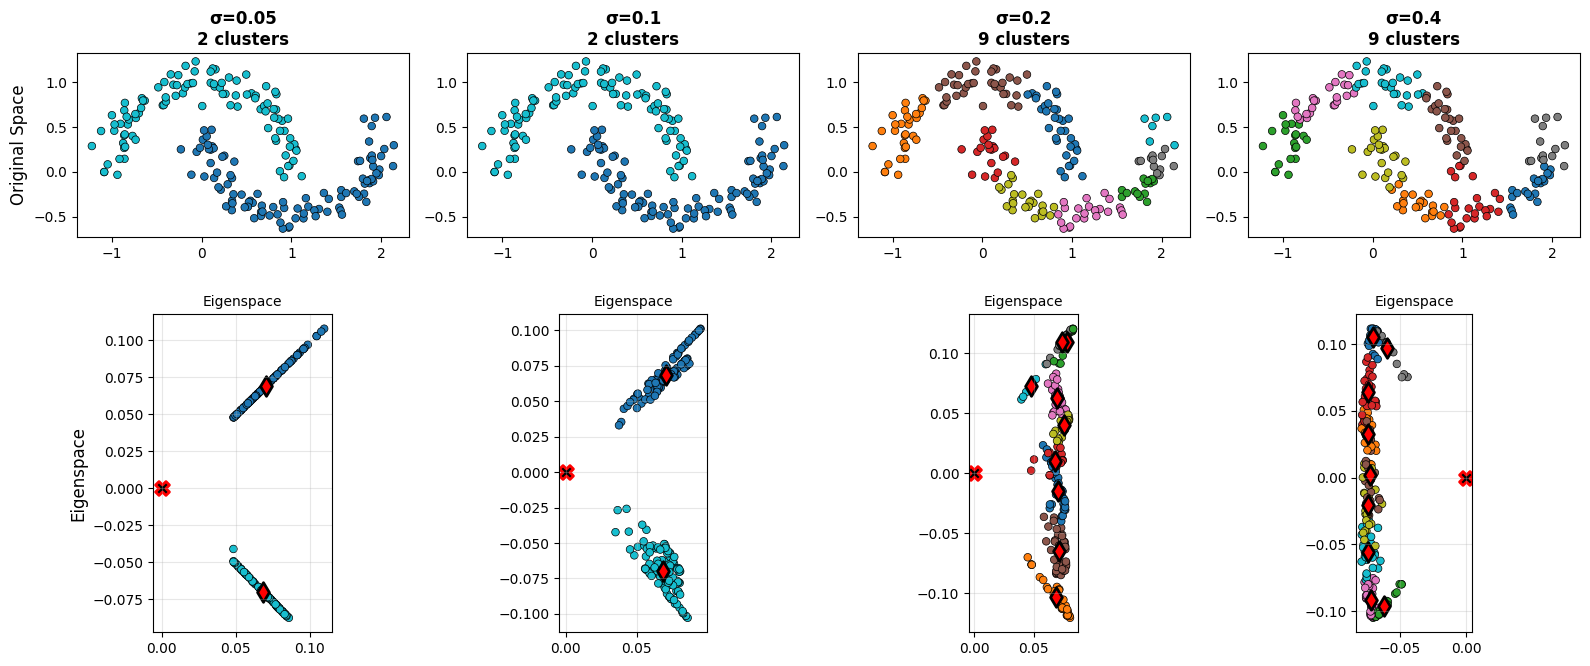


Observations:
  - Too small sigma: Over-segmentation
  - Too large sigma: Under-segmentation
  - Middle range: Correct detection (2 moons)


In [3]:
# Generate two moons dataset
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)

# Test multiple sigma values
sigmas = [0.05, 0.1, 0.2, 0.4]

fig, axes = plt.subplots(2, len(sigmas), figsize=(16, 7))

for i, sigma in enumerate(sigmas):
    clf = SpectralCluster(sigma=sigma, random_state=1)
    clf.fit(X_moons)

    # Original space
    axes[0, i].scatter(X_moons[:, 0], X_moons[:, 1], c=clf.labels_,
                       cmap='tab10', s=30, edgecolors='k', linewidths=0.5)
    axes[0, i].set_title(f'σ={sigma}\n{clf.n_clusters_} clusters', fontweight='bold')
    axes[0, i].set_aspect('equal')

    # Eigenspace
    eigenvecs = clf.eigenvectors_
    axes[1, i].scatter(eigenvecs[:, 0], eigenvecs[:, 1], c=clf.labels_,
                       cmap='tab10', s=30, edgecolors='k', linewidths=0.5)
    axes[1, i].scatter(clf.centers_[:, 0], clf.centers_[:, 1],
                       c='red', s=100, marker='d', edgecolors='k', linewidths=2)
    axes[1, i].scatter([0], [0], c='black', s=100, marker='X',
                       edgecolors='red', linewidths=2)
    axes[1, i].set_title('Eigenspace', fontsize=10)
    axes[1, i].set_aspect('equal')
    axes[1, i].grid(True, alpha=0.3)

axes[0, 0].set_ylabel('Original Space', fontsize=12)
axes[1, 0].set_ylabel('Eigenspace', fontsize=12)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - Too small sigma: Over-segmentation")
print("  - Too large sigma: Under-segmentation")
print("  - Middle range: Correct detection (2 moons)")

## 2. Sigma Selection Guidelines

### Rule of Thumb

Start with $\sigma$ around the **average distance to k-th nearest neighbor** (k=5-10):

$$\sigma \approx \text{mean}(d_k(x_i))$$

where $d_k(x_i)$ is the distance from point $i$ to its $k$-th nearest neighbor.


Estimated sigma for two moons: 0.191


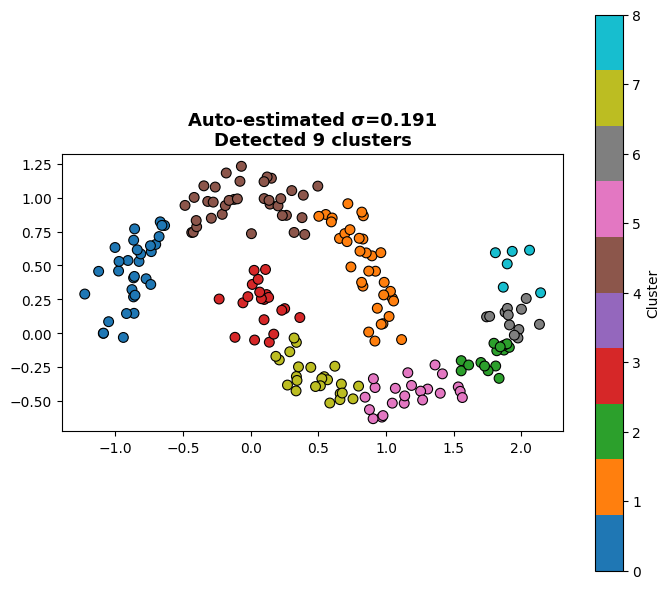


Result: 9 clusters detected
⚠ May need manual adjustment.


In [4]:
from sklearn.neighbors import NearestNeighbors

def estimate_sigma(X, k=7):
    """Estimate sigma from k-nearest neighbor distances."""
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    # Skip first column (distance to self = 0)
    knn_dists = distances[:, 1:]
    # Average distance to k-th neighbor
    sigma_est = knn_dists[:, -1].mean()
    return sigma_est

# Estimate for two moons
sigma_est = estimate_sigma(X_moons, k=7)
print(f"\nEstimated sigma for two moons: {sigma_est:.3f}")

# Test it
clf_auto = SpectralCluster(sigma=sigma_est, random_state=1)
clf_auto.fit(X_moons)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
scatter = ax.scatter(X_moons[:, 0], X_moons[:, 1], c=clf_auto.labels_,
                     cmap='tab10', s=50, edgecolors='k', linewidths=0.8)
ax.set_title(f'Auto-estimated σ={sigma_est:.3f}\nDetected {clf_auto.n_clusters_} clusters',
             fontsize=13, fontweight='bold')
ax.set_aspect('equal')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

print(f"\nResult: {clf_auto.n_clusters_} clusters detected")
if clf_auto.n_clusters_ == 2:
    print("✓ Perfect! Auto-estimation worked.")
else:
    print("⚠ May need manual adjustment.")

## 3. Effect of Lambda ($\lambda$)

Lambda controls the **elongation** in the Mahalanobis distance used by k-means:

$$d^2(x, c) = \lambda \|x - c\|^2 + (1-\lambda) \langle x - c, \hat{c} \rangle^2$$

where $\hat{c} = c / \|c\|$ (unit vector in direction of center).

**Effect**:
- **$\lambda = 1$**: Standard Euclidean k-means (no elongation)
- **$\lambda < 1$**: Elongated k-means (favors radial clustering)
- **$\lambda = 0$**: Pure radial distance (angle-only clustering)

Default is $\lambda = 0.1$ (strong elongation), which works well for eigenspace clustering.

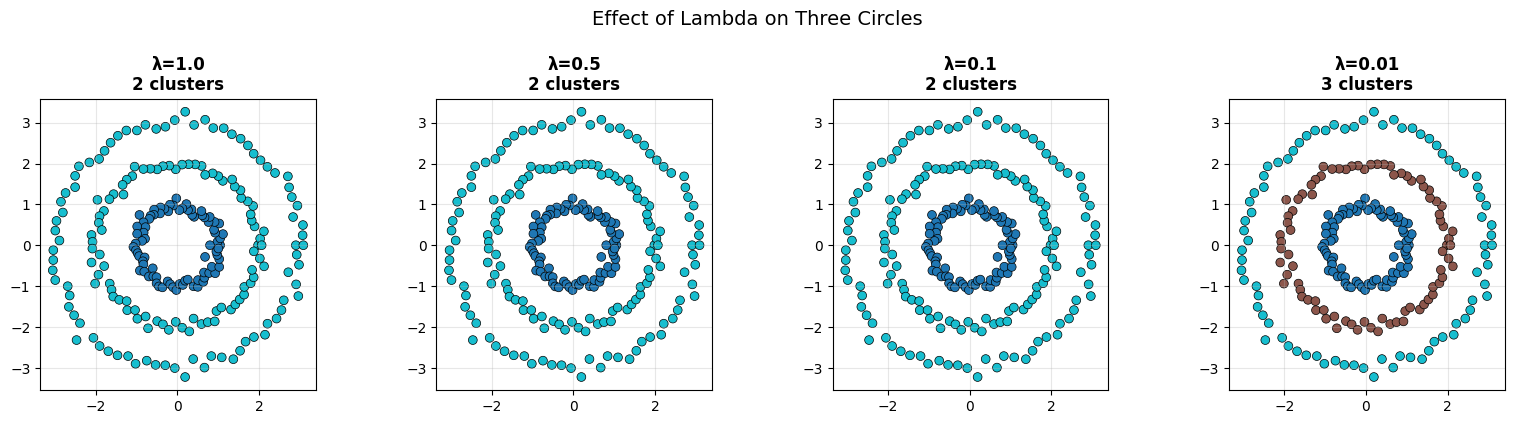


Observations:
  - λ=1.0: May fail to separate radial structure
  - λ=0.1 (default): Good for radial clustering
  - λ too small: May over-separate


In [5]:
# Generate three concentric circles
def make_three_circles(n_samples=100):
    theta = np.linspace(0, 2*np.pi, n_samples)
    noise = 0.1

    r1 = 1 + noise * np.random.randn(n_samples)
    r2 = 2 + noise * np.random.randn(n_samples)
    r3 = 3 + noise * np.random.randn(n_samples)

    X = np.vstack([
        np.column_stack([r1 * np.cos(theta), r1 * np.sin(theta)]),
        np.column_stack([r2 * np.cos(theta), r2 * np.sin(theta)]),
        np.column_stack([r3 * np.cos(theta), r3 * np.sin(theta)])
    ])
    return X

X_circles = make_three_circles(n_samples=80)

# Test different lambda values
lambdas = [1.0, 0.5, 0.1, 0.01]

fig, axes = plt.subplots(1, len(lambdas), figsize=(16, 4))

for i, lam in enumerate(lambdas):
    clf = SpectralCluster(sigma=0.158, lambda_=lam, random_state=1)
    clf.fit(X_circles)

    axes[i].scatter(X_circles[:, 0], X_circles[:, 1], c=clf.labels_,
                    cmap='tab10', s=40, edgecolors='k', linewidths=0.5)
    axes[i].set_title(f'λ={lam}\n{clf.n_clusters_} clusters', fontweight='bold')
    axes[i].set_aspect('equal')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Effect of Lambda on Three Circles', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - λ=1.0: May fail to separate radial structure")
print("  - λ=0.1 (default): Good for radial clustering")
print("  - λ too small: May over-separate")

## 4. Max Clusters Parameter

The algorithm iteratively increases dimensionality until it finds the correct number of clusters, but needs an upper bound to prevent runaway.

**Default**: `max_clusters=10`

**When to adjust**:
- Increase if you expect many clusters
- Decrease to speed up computation on large datasets

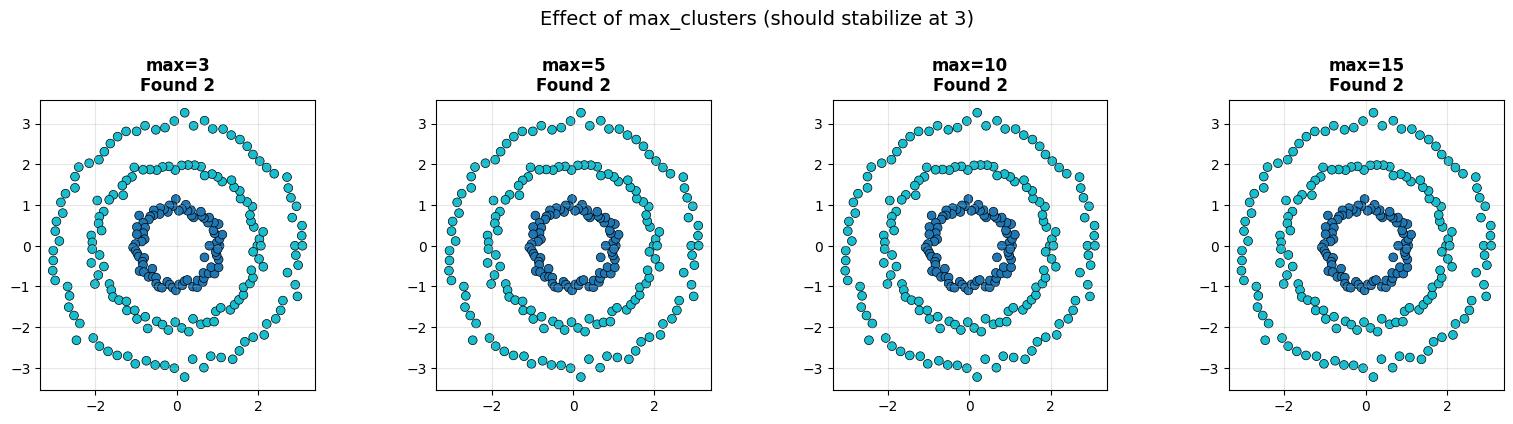


For three circles, algorithm should detect 3 clusters regardless of max_clusters (as long as max >= 3).


In [6]:
# Test with different max_clusters
max_clusters_values = [3, 5, 10, 15]

fig, axes = plt.subplots(1, len(max_clusters_values), figsize=(16, 4))

for i, max_c in enumerate(max_clusters_values):
    clf = SpectralCluster(sigma=0.158, max_clusters=max_c, random_state=1)
    clf.fit(X_circles)

    axes[i].scatter(X_circles[:, 0], X_circles[:, 1], c=clf.labels_,
                    cmap='tab10', s=40, edgecolors='k', linewidths=0.5)
    axes[i].set_title(f'max={max_c}\nFound {clf.n_clusters_}', fontweight='bold')
    axes[i].set_aspect('equal')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Effect of max_clusters (should stabilize at 3)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nFor three circles, algorithm should detect 3 clusters regardless of max_clusters (as long as max >= 3).")

## 5. When Does the Algorithm Struggle?

The algorithm works best on:
- Non-convex, radially-structured data
- Well-separated clusters
- Moderate dimensionality

It may struggle with:
- Very high-dimensional data (curse of dimensionality)
- Highly overlapping clusters
- Non-uniform density
- Very unbalanced cluster sizes

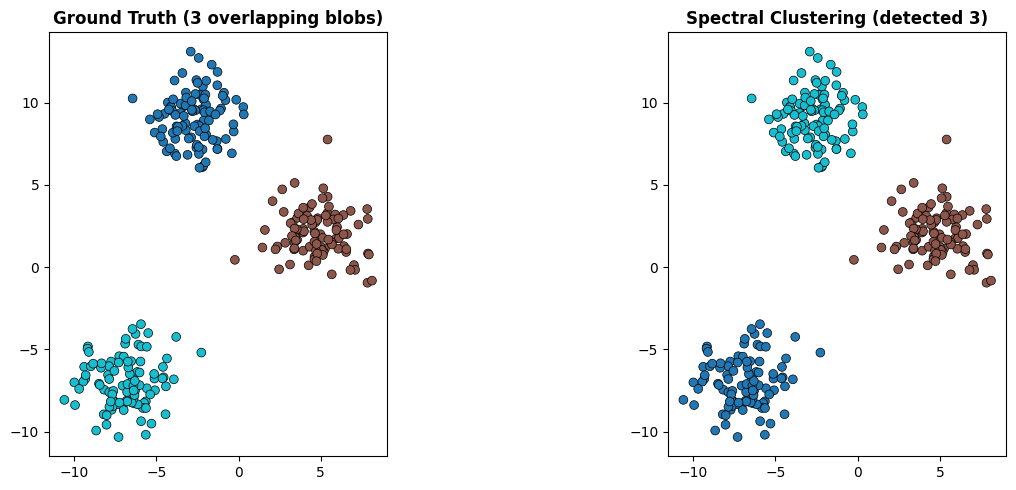


Challenging case: Overlapping Gaussian blobs
Detected 3 clusters (true: 3)

Why it struggles:
  - Spectral clustering expects non-convex/radial structure
  - Overlapping Gaussians are better suited for GMM or standard k-means


In [7]:
# Example: Overlapping clusters
from sklearn.datasets import make_blobs

X_overlap, y_overlap = make_blobs(n_samples=300, centers=3, n_features=2,
                                   cluster_std=1.5, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground truth
axes[0].scatter(X_overlap[:, 0], X_overlap[:, 1], c=y_overlap,
                cmap='tab10', s=40, edgecolors='k', linewidths=0.5)
axes[0].set_title('Ground Truth (3 overlapping blobs)', fontweight='bold')
axes[0].set_aspect('equal')

# Spectral clustering
sigma_est_overlap = estimate_sigma(X_overlap, k=7)
clf_overlap = SpectralCluster(sigma=sigma_est_overlap, random_state=1)
clf_overlap.fit(X_overlap)

axes[1].scatter(X_overlap[:, 0], X_overlap[:, 1], c=clf_overlap.labels_,
                cmap='tab10', s=40, edgecolors='k', linewidths=0.5)
axes[1].set_title(f'Spectral Clustering (detected {clf_overlap.n_clusters_})',
                  fontweight='bold')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nChallenging case: Overlapping Gaussian blobs")
print(f"Detected {clf_overlap.n_clusters_} clusters (true: 3)")
print("\nWhy it struggles:")
print("  - Spectral clustering expects non-convex/radial structure")
print("  - Overlapping Gaussians are better suited for GMM or standard k-means")

## 6. Practical Workflow

Here's a recommended workflow for applying spectral clustering to new data:

### Step 1: Explore the data
- Visualize if possible
- Check for non-convex structure
- Estimate typical distances

### Step 2: Initial sigma estimate
```python
from sklearn.neighbors import NearestNeighbors
k = 7  # typical value
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
distances, _ = nbrs.kneighbors(X)
sigma_init = distances[:, -1].mean()
```

### Step 3: Try a range of sigmas
```python
sigma_range = [0.5*sigma_init, sigma_init, 2*sigma_init]
for sigma in sigma_range:
    clf = SpectralCluster(sigma=sigma)
    clf.fit(X)
    print(f"σ={sigma:.3f}: {clf.n_clusters_} clusters")
```

### Step 4: Validate results
- Visual inspection
- Domain knowledge
- Silhouette score (if appropriate)

### Step 5: Fine-tune if needed
- Adjust sigma for desired granularity
- Consider lambda if radial structure is weak
- Increase max_clusters if needed

In [8]:
# Example workflow on two moons
print("WORKFLOW DEMO: Two Moons Dataset")
print("="*60)

# Step 1: Explore
print("\nStep 1: Data exploration")
print(f"  Shape: {X_moons.shape}")
print(f"  Min/max: [{X_moons.min():.2f}, {X_moons.max():.2f}]")

# Step 2: Estimate sigma
sigma_init = estimate_sigma(X_moons, k=7)
print(f"\nStep 2: Initial sigma estimate")
print(f"  σ_init = {sigma_init:.3f}")

# Step 3: Try range
print(f"\nStep 3: Test sigma range")
sigma_range = [0.5*sigma_init, sigma_init, 2*sigma_init]
results = []
for sigma in sigma_range:
    clf = SpectralCluster(sigma=sigma, random_state=1)
    clf.fit(X_moons)
    print(f"  σ={sigma:.3f}: {clf.n_clusters_} clusters detected")
    results.append((sigma, clf.n_clusters_))

# Step 4: Choose best
print(f"\nStep 4: Selection")
# For two moons, we want 2 clusters
best_sigma = [s for s, n in results if n == 2]
if best_sigma:
    print(f"  ✓ Found correct clustering with σ={best_sigma[0]:.3f}")
else:
    print(f"  ⚠ None detected 2 clusters - may need more adjustment")

print("\n" + "="*60)

WORKFLOW DEMO: Two Moons Dataset

Step 1: Data exploration
  Shape: (200, 2)
  Min/max: [-1.23, 2.14]

Step 2: Initial sigma estimate
  σ_init = 0.191

Step 3: Test sigma range
  σ=0.096: 2 clusters detected
  σ=0.191: 9 clusters detected
  σ=0.382: 9 clusters detected

Step 4: Selection
  ✓ Found correct clustering with σ=0.096



## 7. Summary: Parameter Selection Guidelines

### Sigma ($\sigma$)

| Scenario | Recommendation |
|----------|---------------|
| **Starting point** | Mean k-NN distance (k=5-10) |
| **Coarse clustering** | Smaller sigma (0.5× initial) |
| **Fine clustering** | Larger sigma (2× initial) |
| **Dense data** | Smaller sigma |
| **Sparse data** | Larger sigma |

### Lambda ($\lambda$)

| Scenario | Recommendation |
|----------|---------------|
| **Strong radial structure** | λ = 0.01 - 0.1 (default: 0.1) |
| **Weak radial structure** | λ = 0.3 - 0.5 |
| **No radial structure** | λ = 1.0 (standard k-means) |

### Max Clusters

| Scenario | Recommendation |
|----------|---------------|
| **General use** | 10 (default) |
| **Many clusters expected** | 15-20 |
| **Few clusters expected** | 5-8 |
| **Large dataset** | Lower value for speed |

### Red Flags

**Algorithm may not be suitable if**:
- Clusters are well-separated Gaussian blobs → Use GMM or k-means
- Data is very high-dimensional → Consider dimensionality reduction first
- Clusters have vastly different densities → May need preprocessing
- Linear separability → Try simpler methods first

**Algorithm excels when**:
- Clusters are non-convex
- Radial or circular structure
- Don't know number of clusters
- Interested in multiple scales

## Conclusion

This notebook provided:
- Systematic exploration of parameters
- Practical selection guidelines
- Working examples
- Workflow recommendations

Remember: **No single parameter setting works for all data**. Always explore, visualize, and validate!

## References

- Paper: Sanguinetti et al. (2005)
- Implementation: `spectral/cluster.py`
- Previous notebooks: 01-04 for specific application examples